# 파이썬으로 에이다라인 구현하기

In [1]:
import numpy as np

In [11]:
class AdalineGD(object):
    """ADAPtive LInear NEuron classifier.
    
    Parameters
    -----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
        
    Attributes
    ------------
    w_ : 1d-array
        weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
        
    """
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter
        
    
    def fit(self, X, y):
        """Fit training data.
        Parameters
        -----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples
            is the number of samples and n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.
            Returns
        ------------
        self : object
        """
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
              
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

In [31]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
y = df.iloc[0:200, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)
X = df.iloc[0:200, [0,2]].values

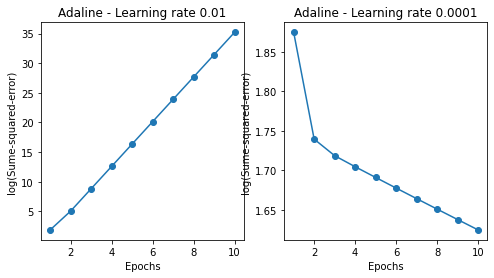

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows =1, ncols=2, figsize=(8, 4))
ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) +1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sume-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')
ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) +1), np.log10(ada2.cost_), marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('log(Sume-squared-error)')
ax[1].set_title('Adaline - Learning rate 0.0001')
plt.show()

# 데이터에 표준 정규분포의 성격 부여하는 표준화

In [33]:
X_std = np.copy(X)
X_std[:, 0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:, 1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

In [34]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


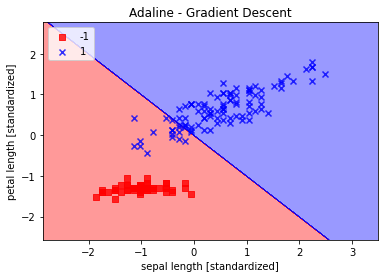

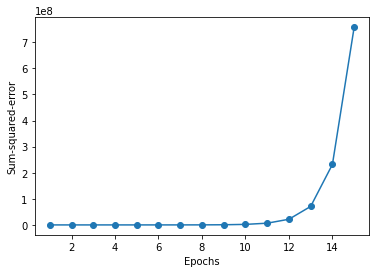

In [35]:
from matplotlib.colors import ListedColormap
ada = AdalineGD(n_iter = 15, eta= 0.01)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, classifier = ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc = 'upper left')
plt.show()
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.show()

# 확률적 그레디언트 디센트

In [36]:
from numpy.random import seed

In [37]:
class AdalineSGD(object):
    """ADAPtive LInear NEuron classifier.
    
    Parameters
    -----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
        
    Attributes
    ------------
    w_ : 1d-array
        weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch
        if True to prevent cycles.
    random_state : int (default: None)
        Set random state for shuffling
        and initializing the weights.
    """
    
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
            
    def fit(self, X, y):
        """Fit training data.
        Parameters
        -----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples
            is the number of samples and n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.
            Returns
        ------------
        self : object
        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        """Fit training data without reinitalizing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        """Shuffle taining data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """Initialize weights to zeros"""
        self.w_ = np.zeros(1 +m)
        self.w_initialized =  True
        
    def _update_weights(self, xi, target):
        """Applt Adaline learning rule to update the weights"""
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


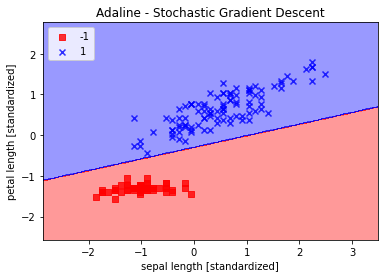

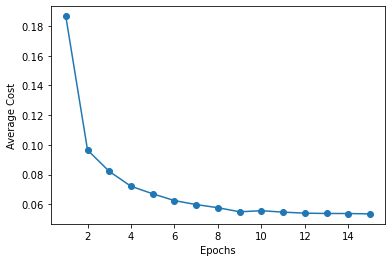

In [38]:
ada = AdalineSGD(n_iter = 15, eta= 0.01, random_state=1)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, classifier = ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc = 'upper left')
plt.show()
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.show()

In [39]:
ada.partial_fit(X_std[0,:], y[0])